In [3]:
%matplotlib inline
import nengo
import nengo_spa as spa
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

In [4]:
def power(s, e):
    x = np.fft.ifft(np.fft.fft(s.v) ** e).real
    return spa.SemanticPointer(data=x)

In [8]:
def create_vocab(dim=512, seed=2):
    vocab = spa.Vocabulary(dimensions=dim)
    vocab.populate('BICYCLE; CAR; MOTORCYCLE; PEDESTRIAN; STATIONARY; TRUCK; UNKNOWN')
    
    spatial_ids = ['POS_X',
                         'POS_Y',
                         'VEL_X',
                         'VEL_Y',
                         'ACC_X',
                         'ACC_Y',
                         'REL_LANE',
                         'DIST_LEFT_LANE_BORDER',
                         'DIST_RIGHT_LANE_BORDER']
    
    for k in spatial_ids:
        vocab.populate(k+'.unitary()')
    return vocab

In [113]:
def plot(img, limit, xx, dim=None, gtx=None, gty=None, tidx=None, cmin=0.0, cmax=1.0):
    from matplotlib import cm
    from matplotlib import colors
    label_font_size = 24
    tick_font_size = 20
    legend_font_size = 24
    b_gt = False
    
    if gtx is not None and gty is not None:
        b_gt = True
    
    plt.figure(figsize=(40,10))
    plt.subplot(1,3,1)
    if tidx is not None:
        plt.title('time exponent: %i'%tidx)
    cax = plt.imshow(img, interpolation='none', extent=(-limit,limit,limit,-limit), cmap=cm.viridis, norm=colors.Normalize(vmin=cmin, vmax=cmax))
    if b_gt:
        plt.scatter(gtx, gty, facecolors='none', edgecolors='r')
    #cbar = pylab.colorbar(cax, ticks=np.arange(-1,1.1, 0.2))
    
    cbar = plt.colorbar(cax, boundaries=np.linspace(cmin, cmax, 20, endpoint=True), ticks=np.round(np.linspace(cmin, cmax, 20, endpoint=True), 3))
    cbar.ax.set_ylabel('Similarity', rotation=90, fontsize=label_font_size)
    cbar.ax.tick_params(labelsize=tick_font_size)

    plt.ylabel('y-coordinates', fontsize=label_font_size)
    plt.xlabel('x-coordinates', fontsize=label_font_size)
    plt.xticks(fontsize=tick_font_size)
    plt.yticks(fontsize=tick_font_size)
#     for tick in cax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(20) 
#     for tick in cax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(20) 

    ax1 = plt.subplot(1,3,2)
    ax1.grid(ls=':')
    ax1.set_ylim([cmin,cmax])
    for ind1,_ in enumerate(xx):
        plt.plot(xx, img[ind1,:])
    if dim is not None:
        plt.axhline(2/np.sqrt(dim), ls='--', c='k', alpha=0.5, label='weak similarity threshold')
        plt.axhline(3/np.sqrt(dim), ls='--', c='m', alpha=0.5, label='strong similarity threshold')
    
    if b_gt:
        for i, gx in enumerate(gtx):
            if i < len(gtx)-1:
                plt.axvline(gx, ls='--', alpha=1.)
            else:
                plt.axvline(gx, ls='--', alpha=1., label='actual x')

    plt.legend(loc=4, fontsize=legend_font_size)
    plt.ylabel('Similarity', fontsize=label_font_size)
    plt.xlabel('x-coordinates', fontsize=label_font_size)
    
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(tick_font_size) 
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(tick_font_size) 

    ax2 = plt.subplot(1,3,3)
    ax2.grid(ls=':')
    ax2.set_ylim([cmin,cmax])
    for ind1,_ in enumerate(xx):
        plt.plot(xx, img[:,ind1])
    if dim is not None:
        plt.axhline(2/np.sqrt(dim), ls='--', c='k', alpha=0.5, label='weak similarity threshold')
        plt.axhline(3/np.sqrt(dim), ls='--', c='m', alpha=0.5, label='strong similarity threshold')
        
    if b_gt:
        for i, gy in enumerate(gty):
            if i < len(gty)-1:
                plt.axvline(gy, ls='--', alpha=1.)
            else:
                plt.axvline(gy, ls='--', alpha=1., label='actual y')

    plt.legend(loc=4, fontsize=legend_font_size)
    plt.ylabel('Similarity', fontsize=label_font_size)
    plt.xlabel('y-coordinates', fontsize=label_font_size)
    
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(tick_font_size) 
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(tick_font_size) 


    pylab.show()

In [32]:
D=512
vocab = create_vocab(D, 3)
print(list(vocab.keys()))

['BICYCLE', 'CAR', 'MOTORCYCLE', 'PEDESTRIAN', 'STATIONARY', 'TRUCK', 'UNKNOWN', 'POS_X', 'POS_Y', 'VEL_X', 'VEL_Y', 'ACC_X', 'ACC_Y', 'REL_LANE', 'DIST_LEFT_LANE_BORDER', 'DIST_RIGHT_LANE_BORDER']


In [82]:
ns = 2
xs = np.round(np.random.uniform(-0.99,1,ns), 3)
ys = np.round(np.random.uniform(-0.99,1,ns), 3)
ts = np.linspace(0.1,3,ns)
print(xs)
print(ys)

[-0.753 -0.162]
[-0.502  0.621]


In [106]:
limit = 10


v = spa.SemanticPointer(np.zeros(D))
w = spa.SemanticPointer(np.zeros(D))
for ind ,(t, x, y) in enumerate(zip(ts, xs, ys)):
    if ind < len(xs)//2:
        v += vocab['CAR']*power(vocab['POS_X'],x*limit)*power(vocab['POS_Y'],y*limit)
        w += vocab['CAR']*power(vocab['POS_X'],x*limit)*power(vocab['POS_Y'],y*limit)
    else:
#         v += vocab['TRUCK']*power(vocab['POS_X'],x*limit)*power(vocab['POS_Y'],y*limit)
        w += vocab['CAR']*power(vocab['POS_X'],x*limit)*power(vocab['POS_Y'],y*limit)
#     w += power(T, (ind-ts.shape[0])) * (power(X, x*limit)*power(Y, y*limit) + power(X, x1*limit)*power(Y, y1*limit))

In [107]:
M = 100
xx = np.linspace(-limit, limit, M)
yy = np.linspace(-limit, limit, M)
ii = np.arange(0,ns)

vs = np.zeros((M,M))
ws = np.zeros((M,M))
for i,x in enumerate(xx):
    for j, y in enumerate(yy):
#         for ind in ii:
        test_v = power(vocab['POS_X'],x)*power(vocab['POS_Y'],y)
        vs[j,i] = test_v.compare(vocab['CAR'].__invert__()*v)
        ws[j,i] = test_v.compare(vocab['CAR'].__invert__()*w)


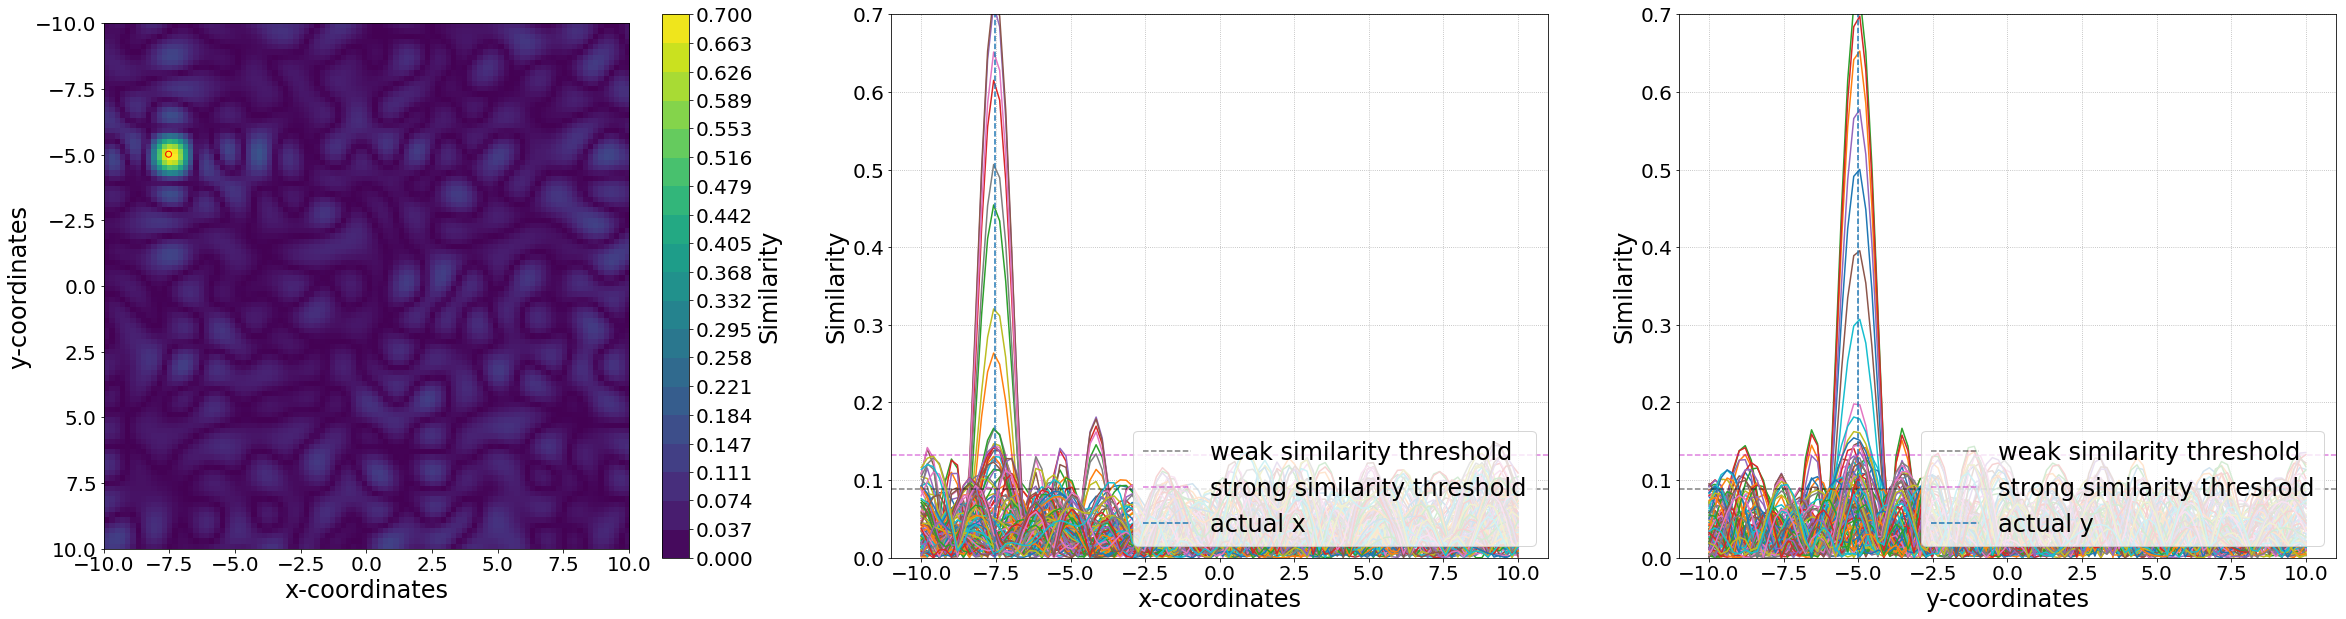

In [114]:
%matplotlib inline
plot(np.abs(vs), limit, xx, dim=D, gtx=xs[:len(xs)//2]*limit, gty=ys[:len(ys)//2]*limit, tidx=None, cmin=0.0, cmax=0.7)

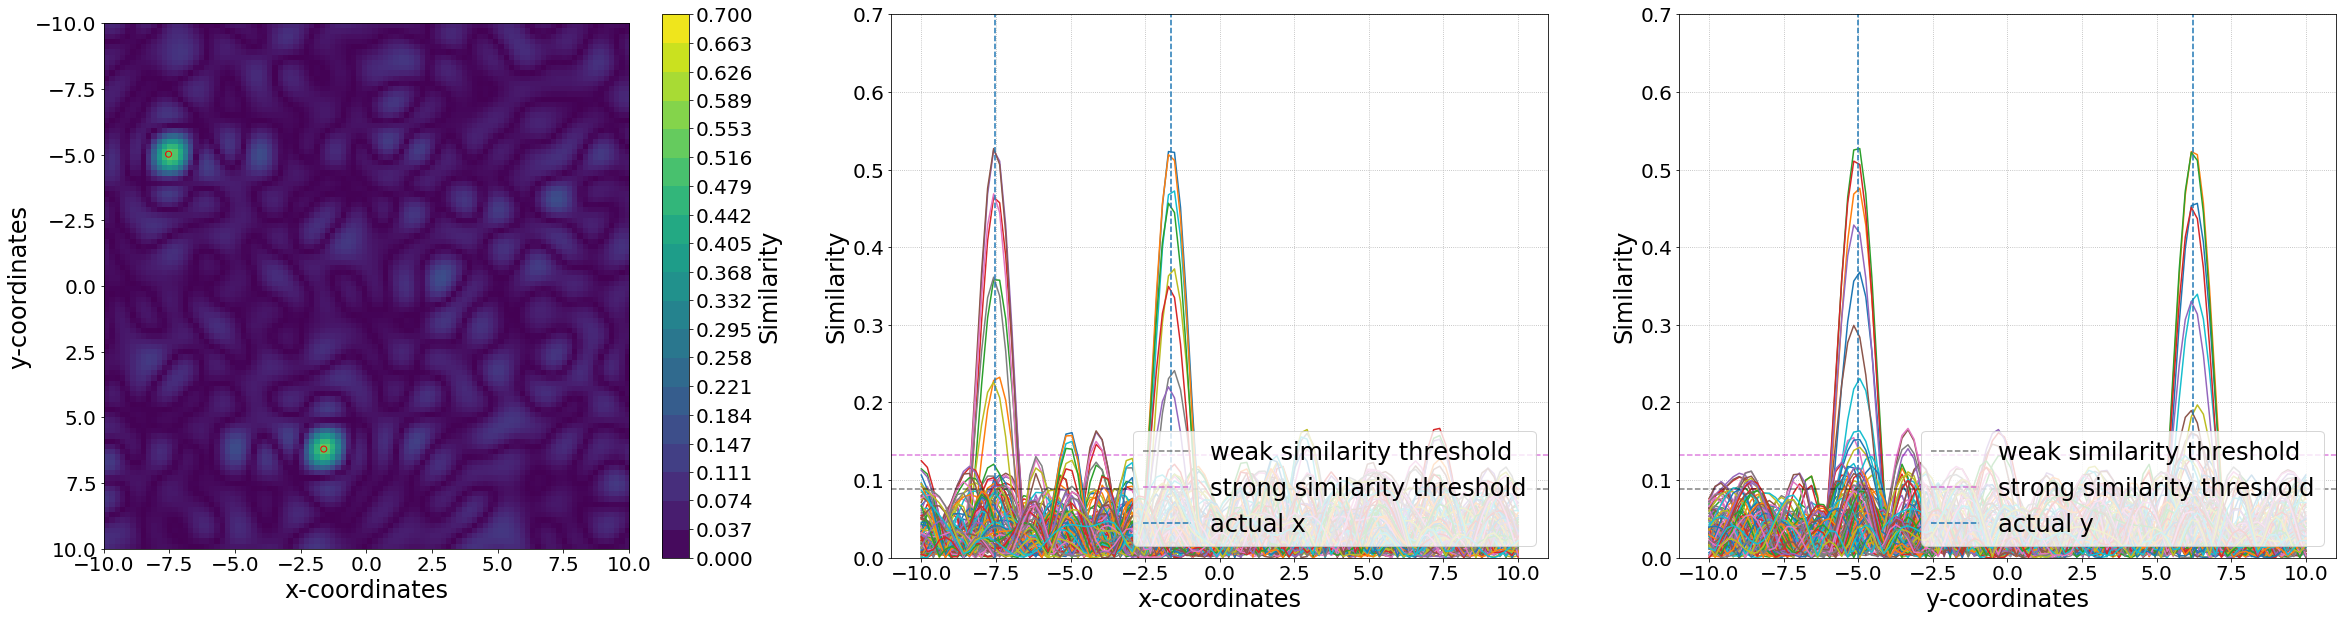

In [115]:
%matplotlib inline
plot(np.abs(ws), limit, xx, dim=D, gtx=xs*limit, gty=ys*limit, tidx=None, cmin=0.0, cmax=0.7)

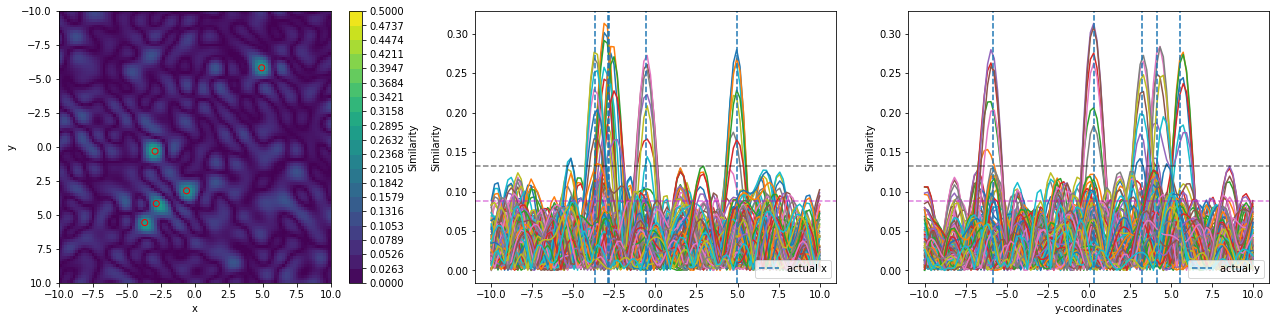

In [38]:
M = 100
xx = np.linspace(-limit, limit, M)
yy = np.linspace(-limit, limit, M)
ii = np.arange(0,ns)

vs = np.zeros((M,M))

for i,x in enumerate(xx):
    for j, y in enumerate(yy):
#         for ind in ii:
        test_v = power(vocab['POS_X'],x)*power(vocab['POS_Y'],y)
        vs[j,i] = test_v.compare(vocab['TRUCK'].__invert__()*v)
%matplotlib inline
plot(np.abs(vs), limit, xx, dim=D, gtx=xs[len(xs)//2:]*10, gty=ys[len(ys)//2:]*10, tidx=None)

<IPython.core.display.Javascript object>


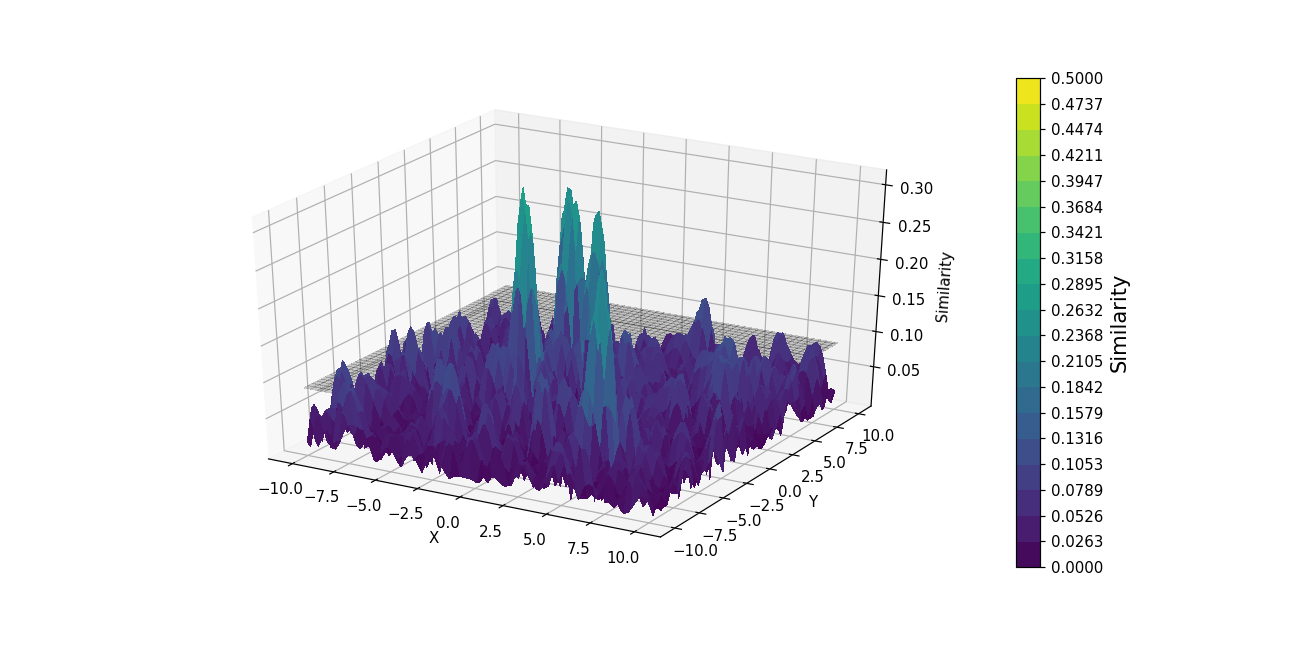

Text(0.5, 0, 'Similarity')

In [58]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure(figsize=(12,6))
ax = fig.gca(projection='3d')
mx, my = np.meshgrid(xx, yy)
surf = ax.plot_surface(mx, my, np.abs(vs), cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=0.5),
                       linewidth=0, antialiased=False)
surf1 = ax.plot_surface(mx, my, np.ones((M,M))*(2/np.sqrt(D)), color='k',
                       linewidth=0, antialiased=False, alpha=0.2)
cb = fig.colorbar(surf, boundaries=np.linspace(0.0, 0.5, 20, endpoint=True), ticks=np.linspace(0.0, 0.5, 20, endpoint=True))
cb.set_label('Similarity', rotation=90, fontsize=14)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Similarity')

<IPython.core.display.Javascript object>


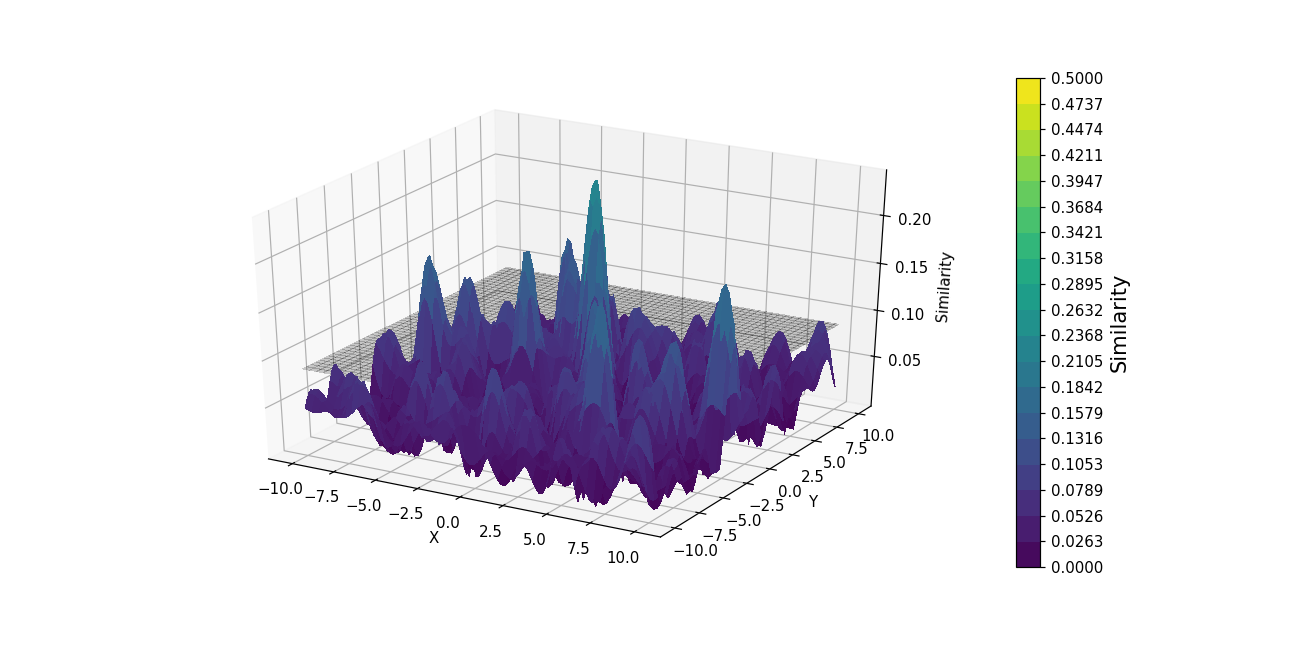

Text(0.5, 0, 'Similarity')

In [62]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure(figsize=(12,6))
ax = fig.gca(projection='3d')
mx, my = np.meshgrid(xx, yy)
surf = ax.plot_surface(mx, my, np.abs(ws), cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=0.5),
                       linewidth=0, antialiased=False)
surf1 = ax.plot_surface(mx, my, np.ones((M,M))*(2/np.sqrt(D)), color='k',
                       linewidth=0, antialiased=False, alpha=0.2)
cb = fig.colorbar(surf, boundaries=np.linspace(0.0, 0.5, 20, endpoint=True), ticks=np.linspace(0.0, 0.5, 20, endpoint=True))
cb.set_label('Similarity', rotation=90, fontsize=14)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Similarity')

In [35]:
M = 100
xx = np.linspace(-limit, limit, M)
yy = np.linspace(-limit, limit, M)
ii = np.arange(0,ns)
positives = []
negatives = []
vs = np.zeros((M,M))
ws = np.zeros((M,M))
for i,x in enumerate(xx):
    for j, y in enumerate(yy):
#         for ind in ii:
        cx = np.isclose(xs[5:]*10, np.ones(xs[5:].shape)*x, atol=0.4, rtol=0)
        cy = np.isclose(ys[5:]*10, np.ones(ys[5:].shape)*y, atol=0.4, rtol=0)
        test_v = power(vocab['POS_X'],x)*power(vocab['POS_Y'],y)
        vs[j,i] = test_v.compare(vocab['TRUCK'].__invert__()*v)
        dot_p = test_v.compare(vocab['TRUCK'].__invert__()*v)
        if np.any(np.logical_and(cx, cy)):
#             print('true x=%1.3f, y=%1.3f'%(10*xs[5:][np.logical_and(cx, cy)][0], 10*ys[5:][np.logical_and(cx, cy)][0]))
#             print('positive dot %1.3f at x=%1.3f, y=%1.3f'%(dot_p, x,y))
            positives.append(dot_p)
            negatives.append(np.NaN)
        else:
#             if np.abs(dot_p) > 0.3:
#                 print('----------------------')
#                 print('high negative dot %1.3f at x=%1.3f, y=%1.3f'%(dot_p, x,y))
#                 print('----------------------')
            negatives.append(dot_p)
            positives.append(np.NaN)

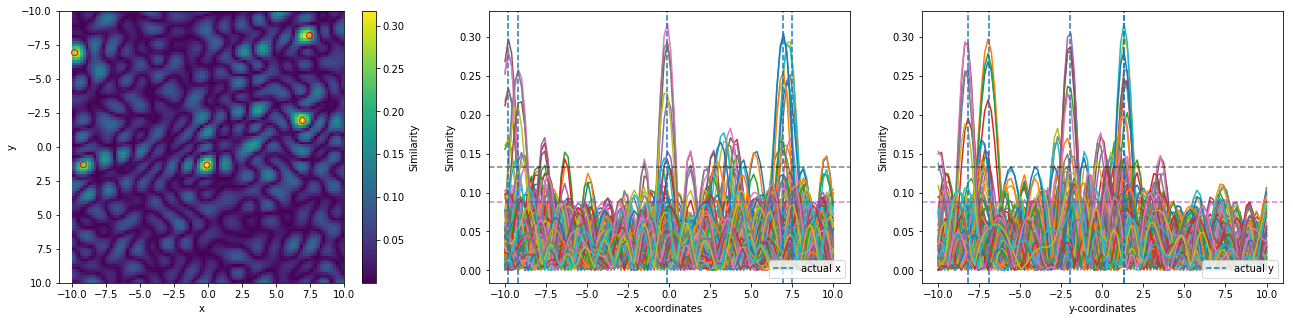

[-9.19  7.46 -0.1   6.93 -9.84]
[ 1.31 -8.2   1.34 -1.95 -6.94]


In [36]:
%matplotlib inline
plot(np.abs(vs), limit, xx, dim=D, gtx=xs[len(xs)//2:]*10, gty=ys[len(ys)//2:]*10, tidx=None)
print(xs[5:]*10)
print(ys[5:]*10)

In [37]:
print(np.nanmean(np.abs(positives)))
print(np.nanmin(positives))
print('---------------')
print(np.nanmean(np.abs(negatives)))
print(np.nanpercentile(np.abs(negatives), 95))
print(np.nanmax(positives))
print(np.nanmax(np.abs(negatives)))


0.24861416950457
0.14682758257803488
---------------
0.03980743959984476
0.09987748969718266
0.31703700745878177
0.2587861936376502


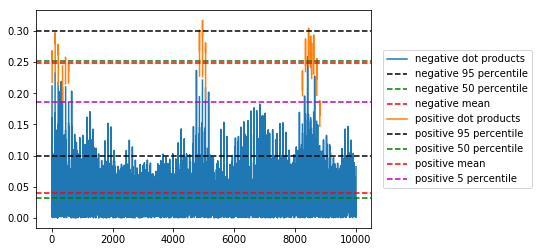

In [40]:
plt.plot(np.abs(negatives), label='negative dot products')
plt.axhline(np.nanpercentile(np.abs(negatives),95), c='k', ls='--', label='negative 95 percentile')
plt.axhline(np.nanpercentile(np.abs(negatives),50), c='g', ls='--', label='negative 50 percentile')
plt.axhline(np.nanmean(np.abs(negatives)), c='r', ls='--', label='negative mean')
# plt.axhline(np.nanpercentile(np.abs(negatives),5), c='m', ls='--')
plt.plot(np.abs(positives), label='positive dot products')
plt.axhline(np.nanpercentile(np.abs(positives),95), c='k', ls='--' , label='positive 95 percentile')
plt.axhline(np.nanpercentile(np.abs(positives),50), c='g', ls='--', label='positive 50 percentile')
plt.axhline(np.nanmean(np.abs(positives)), c='r', ls='--', label='positive mean')
plt.axhline(np.nanpercentile(np.abs(positives),5), c='m', ls='--', label='positive 5 percentile')
plt.legend(loc="center left", bbox_to_anchor=(1.02,0.5), frameon=True)

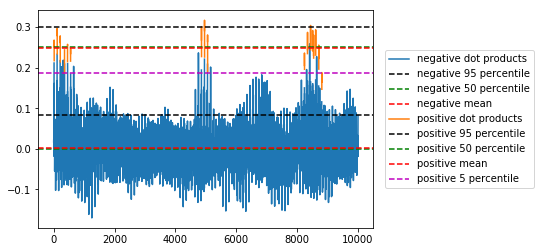

In [39]:
plt.plot(negatives, label='negative dot products')
plt.axhline(np.nanpercentile(negatives,95), c='k', ls='--', label='negative 95 percentile')
plt.axhline(np.nanpercentile(negatives,50), c='g', ls='--', label='negative 50 percentile')
plt.axhline(np.nanmean(negatives), c='r', ls='--', label='negative mean')
# plt.axhline(np.nanpercentile(np.abs(negatives),5), c='m', ls='--')
plt.plot(positives, label='positive dot products')
plt.axhline(np.nanpercentile(positives,95), c='k', ls='--' , label='positive 95 percentile')
plt.axhline(np.nanpercentile(positives,50), c='g', ls='--', label='positive 50 percentile')
plt.axhline(np.nanmean(positives), c='r', ls='--', label='positive mean')
plt.axhline(np.nanpercentile(positives,5), c='m', ls='--', label='positive 5 percentile')
plt.legend(loc="center left", bbox_to_anchor=(1.02,0.5), frameon=True)

In [41]:
M = 100
xx = np.linspace(-limit, limit, M)
yy = np.linspace(-limit, limit, M)
ii = np.arange(0,ns)
positives = []
negatives = []
vs = np.zeros((M,M))
ws = np.zeros((M,M))
for i,x in enumerate(xx):
    for j, y in enumerate(yy):
#         for ind in ii:
        cx = np.isclose(xs[5:]*10, np.ones(xs[5:].shape)*x, atol=0.4, rtol=0)
        cy = np.isclose(ys[5:]*10, np.ones(ys[5:].shape)*y, atol=0.4, rtol=0)
        test_v = power(vocab['POS_X'],x)*power(vocab['POS_Y'],y)
        vs[j,i] = test_v.compare(vocab['CAR'].__invert__()*w)
        dot_p = test_v.compare(vocab['CAR'].__invert__()*w)
        if np.any(np.logical_and(cx, cy)):
#             print('true x=%1.3f, y=%1.3f'%(10*xs[5:][np.logical_and(cx, cy)][0], 10*ys[5:][np.logical_and(cx, cy)][0]))
#             print('positive dot %1.3f at x=%1.3f, y=%1.3f'%(dot_p, x,y))
            positives.append(dot_p)
            negatives.append(np.NaN)
        else:
#             if np.abs(dot_p) > 0.3:
#                 print('----------------------')
#                 print('high negative dot %1.3f at x=%1.3f, y=%1.3f'%(dot_p, x,y))
#                 print('----------------------')
            negatives.append(dot_p)
            positives.append(np.NaN)

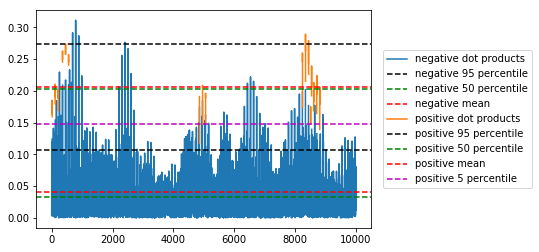

In [42]:
plt.plot(np.abs(negatives), label='negative dot products')
plt.axhline(np.nanpercentile(np.abs(negatives),95), c='k', ls='--', label='negative 95 percentile')
plt.axhline(np.nanpercentile(np.abs(negatives),50), c='g', ls='--', label='negative 50 percentile')
plt.axhline(np.nanmean(np.abs(negatives)), c='r', ls='--', label='negative mean')
# plt.axhline(np.nanpercentile(np.abs(negatives),5), c='m', ls='--')
plt.plot(np.abs(positives), label='positive dot products')
plt.axhline(np.nanpercentile(np.abs(positives),95), c='k', ls='--' , label='positive 95 percentile')
plt.axhline(np.nanpercentile(np.abs(positives),50), c='g', ls='--', label='positive 50 percentile')
plt.axhline(np.nanmean(np.abs(positives)), c='r', ls='--', label='positive mean')
plt.axhline(np.nanpercentile(np.abs(positives),5), c='m', ls='--', label='positive 5 percentile')
plt.legend(loc="center left", bbox_to_anchor=(1.02,0.5), frameon=True)

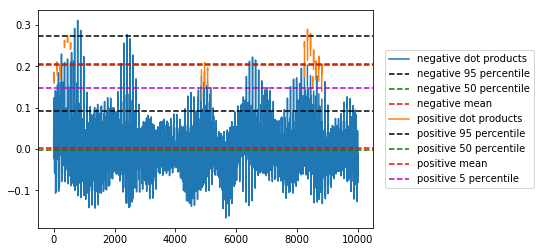

In [43]:
plt.plot(negatives, label='negative dot products')
plt.axhline(np.nanpercentile(negatives,95), c='k', ls='--', label='negative 95 percentile')
plt.axhline(np.nanpercentile(negatives,50), c='g', ls='--', label='negative 50 percentile')
plt.axhline(np.nanmean(negatives), c='r', ls='--', label='negative mean')
# plt.axhline(np.nanpercentile(np.abs(negatives),5), c='m', ls='--')
plt.plot(positives, label='positive dot products')
plt.axhline(np.nanpercentile(positives,95), c='k', ls='--' , label='positive 95 percentile')
plt.axhline(np.nanpercentile(positives,50), c='g', ls='--', label='positive 50 percentile')
plt.axhline(np.nanmean(positives), c='r', ls='--', label='positive mean')
plt.axhline(np.nanpercentile(positives,5), c='m', ls='--', label='positive 5 percentile')
plt.legend(loc="center left", bbox_to_anchor=(1.02,0.5), frameon=True)